In [34]:
import numpy as np
from tqdm import tqdm
import pymc as pm
import skfem as fem
from skfem.helpers import dot, grad, d, dd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import truncnorm
import scipy.sparse as scsparse
import scipy.optimize as scoptimize
import scipy.linalg as sclinalg

import pytensor.tensor.subtensor as subtensor
import pytensor.tensor as tensor
import arviz as az

In [35]:
number_of_x_axial_cells = 64

x_axis_left_boundary = 0.
x_axis_right_boundary = 1.

x_s = np.linspace(x_axis_left_boundary, x_axis_right_boundary, number_of_x_axial_cells)

mesh = fem.MeshLine(x_s)
element = fem.ElementLineP1()
basis = fem.Basis(mesh, element)

true_coordinates = mesh.p.T
n_x = len(true_coordinates)
boundary_condition = (
    (true_coordinates == x_axis_left_boundary) | (true_coordinates == x_axis_right_boundary)
)
boundary_indices = np.where(boundary_condition)[0]

t_start = 0
dt = 0.001
t_end = 0.5
time_range = np.arange(t_start, t_end, dt)
number_of_steps = len(time_range)

u_0true = np.zeros(n_x)
u_strue = np.zeros((number_of_steps, n_x))
u_strue[0,:] = u_0true

In [36]:
# Observation Parameters
sigma_n_true = 0.005
spatial_points = 8
temporal_points = 5
temp = np.linspace(0, len(true_coordinates) - 1, spatial_points+2, dtype=int)
spatial_measurement_indices = temp[1:-1]
temp = np.linspace(0, len(time_range) - 1, temporal_points+2, dtype=int)
temporal_measurement_indices = temp[1:-1]

In [37]:
true_alpha = 1
true_beta = 1

@fem.BilinearForm
def a(u,v,w):
    x = w.x
    return u*v

@fem.BilinearForm
def b(u,v,w):
    x = w.x
    return true_alpha*dot(grad(u),grad(v))

@fem.LinearForm
def l(v,w):
    x = w.x
    f = 8 * np.cos(np.pi*8*x[0]) + true_beta
    return (f)*v
    #return (0.)*v

A_mat = a.assemble(basis)
B_mat = b.assemble(basis)
L_vec = l.assemble(basis)

def boundary_function(boundary_coordinate_list):
    return 0.

pre_OP1 = A_mat + dt*B_mat
pre_OP1[boundary_indices, :] = pre_OP1[:, boundary_indices] = 0.
pre_OP1[boundary_indices, boundary_indices] = 1.
OP1 = scsparse.linalg.inv(pre_OP1)

for i, t in enumerate(time_range):
    OP2 = dt*L_vec + A_mat @ u_strue[i,:]
    OP2[boundary_indices] = boundary_function(true_coordinates[boundary_indices])
    #u_s[i,boundary_indices] = boundary_function(coordinates[boundary_indices])
    #u_s[i+1,:] = dt*OP1 @ L_vec + OP1 @ A_mat @ u_s[i,:]
    u_strue[i+1,:] = OP1 @ OP2

/home/danielclaassen/anaconda3/envs/pymcenv/lib/python3.12/site-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/home/danielclaassen/anaconda3/envs/pymcenv/lib/python3.12/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:603: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
/home/danielclaassen/anaconda3/envs/pymcenv/lib/python3.12/site-packages/scipy/sparse/linalg/_matfuncs.py:76: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  Ainv = spsolve(A, I)


IndexError: index 500 is out of bounds for axis 0 with size 500

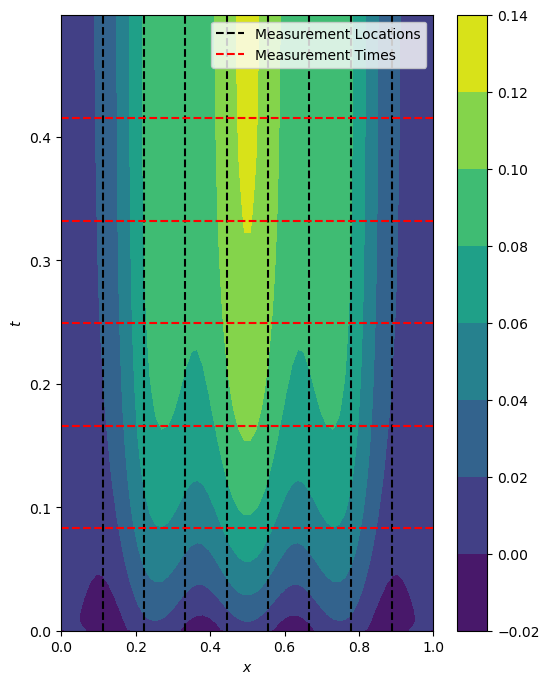

In [47]:
fig, axes = plt.subplots(figsize=(6,8))
plot = axes.contourf(true_coordinates.flatten(), time_range, u_strue)
num = 0
for coord in true_coordinates[spatial_measurement_indices].flatten():
    if num == 0:
        axes.axvline(coord, linestyle='--', label='Measurement Locations', color='black')
    else:
        axes.axvline(coord, linestyle='--', color='black')
    num += 1
num = 0
for coord in time_range[temporal_measurement_indices].flatten():
    if num == 0:
        axes.axhline(coord, linestyle='--', label='Measurement Times', color='red')
    else:
        axes.axhline(coord, linestyle='--', color='red')
    num += 1
axes.set_xlabel(r'$x$')
axes.set_ylabel(r'$t$')
fig.colorbar(plot)
plt.legend()
plt.show()